# Non-CNN Classification Models

In this notebook we seek to make predictive models that do not rely on time frequency analysis.
We will use Spotify's API in order to get song data to fit a logistic regression and a dense neural network to discern genre. This model will serve as another benchmark of success for our CNNs, a way to see how tabular data might serve for the purpose of this project. 

### Imports:

In [ ]:
!pip install Spotipy #needed for google colab notebooks to interact with the spotify api on python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.6/238.6 KB 14.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spotipy
from spotipy import SpotifyClientCredentials

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In order to interact with the spotify API, we need client authentification. This is gained by going to the spotify for developers page and creating a new account, then starting a new project

In [ ]:
cid = #insert your own id
secret = #insert your own key

In [ ]:
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
spot = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

We will be using the "Top 10,000 Songs of All Time" playlist by Aclaimed Music to create a data frame of features with which to fit our model. We chose this playlist simply because it allows us to get a verbose dataset with no knowledge of other individual playlists. Ideally we would want to filter through several playlists, then append to an existing dataset the songs in that new playlist that are already not present, but we lack a list of playlists. Something like the Million Playlists Dataset would be appropriate, but that requires entry to the Alcrowd competition, and this section isn't the focus of our project, we merely want to provide an alternate predictive model to compare our CNN to.

In [ ]:
playlist_link = 'https://open.spotify.com/playlist/1G8IpkZKobrIlXcVPoSIuf?si=f819917d1bca45b8'
playlist_URI = playlist_link.split("/")[-1].split("?")[0]
big_list = []
for i in range(0,9901,100):
    track_uris = [x["track"]["uri"] for x in spot.playlist_tracks(playlist_URI, limit= 100,
                                                                                          offset= i)["items"] 
                  if x["track"] != None ] #exception
    big_list.append(track_uris)
    

In [ ]:
len(big_list)

100

The above loop makes changes to the offset of the calls in order to get around the limiter on the number of songs that can be extracted, which is hard coded into the functions. An important thing to note here is that some of the songs have a value of None for "track". This raises an error with list comprehesions, and created the need for a lot of debugging. Eventually, by attempting each individual call in increments of 100, I was able to find individual examples of what was throwing errors, and created the execption marked above

In [ ]:
from itertools import chain # to compress our list of lists down

In [ ]:
big_list = list(chain.from_iterable(big_list))

In [ ]:
len(big_list)

9998

In [ ]:
spot.track(big_list[0])

looking at how individual song uri's return, we can create the schematics for making a new data set. Because the genres of the song are not part of the json package that gets returned from calling and are instead held on the artist's uri, we need to exract the uris for each artist and extract the genres from there:

In [ ]:
elvis = spot.track(big_list[0])['album']['artists'][0]['uri']
elvis

'spotify:artist:74ASZWbe4lXaubB36ztrGX'

In [ ]:
elvis_info = spot.artist(elvis)

In [ ]:
elvis_info['genres'][0]

'classic rock'

We can only get all the types of genres the artist makes, not the individual genres of the songs. We will assume now that each song is of the type that shows up first in genres. There are also unfortunate errors in future calls caused by the way that links are saved on the spotify servers themselves. Some songs are still playing in the app, but the links to their artist page either have been deleted, or where never logged. This creates the need to create a function that catches these missing uris and saves them so that we can delete them from the overall dataset that we're trying to create. We need to delete them alltogether because there is no other way to extract genre with the current set up of the API:

In [ ]:
artist_uris = []
failed_uris = []
genres = []

In [ ]:
#for i in big_list:
#   try:
#        artist_uri = spot.track(i)['album']['artists'][0]['uri'] 
#        artist_uris.append(artist_uri)
#        genres.append(spot.artist(artist_uri)['genres'][0])
#    except:
#        failed_uris.append(i)
        

The above code will give us 2 lists, one which will have the genres, our y for the data fitting, and a missing list which we would then use to eliminate missing uris from the data set. Unfortunately, the spotify API limits how many calls can be made by an individual project, so the construction of the data set is very limited. Because in order to get genres we need to call the artist uris 1 by one (there is no built in method to do this for multiple artists in one call) this process would have to take place over several days in order to complete even a moderately sized dataset. This is made even more difficult because in order to extract information about the songs using another api method we would need to make individual calls again. The code for fully creating this dataset will be laid out bellow, but because time is limited, we will use the data set that Cameron Watts and his team created in this same fashion in order to do the fitting. Cameron Watts in the article "Extracting Song Data From the Spotify API Using Python" laid out the basic methods for extraction that were followed up until this point, and links to his own repository where they constructed a dataset.

In [ ]:
#filtered_uris = [ x for x in big_list if x not in failed_uris]

In [ ]:
#features = []
#more_failed_uris = []

In [ ]:
#for i in filtered_uris:
#    try:
#        track_feature = spot.audio_features(i)[0]
#        features.append(track_feature)
#    except:
#        more_failed_uris.append(i)

In exactly the same we did above, in order to keep an organized list, we need to keep track of the failing calls to remove them from the data frame. This process, when successful, returns a dictionary of features which we can then utilize for construction of the dataset.

In [ ]:
#refiltered_genres = []

In [ ]:
#re_filtered = [ x['uri'] for x in features if x not in failed_uris]
#for i in big_list:
#  artist_uri = spot.track(i)['album']['artists'][0]['uri'] 
#  refiltered_genres.append(spot.artist(artist_uri)['genres'][0])
        

We now have 2 lists to use for our dataset, one a list of dictioaries and another a list of genres. we can cast them both as a dataframe and have the data we want for fitting:

In [ ]:
#df = pd.DataFrame(data = features, columns = features[0].keys())
#df['genre'] = 
#gen = pd.Series(refiltered_genres)
#df['genre'] = gen.values

The above process would be able to provide us with a usable data set that could have several playlists appended together. This process would need to be done over several days, saving the dataframe of smaller calls and then appending them together into one large data frame. Below we have the modeling provess we wanted to implement on our own dataset but with the dataset created by Cameron Watts and his team:

In [ ]:
music_set = pd.read_csv('https://raw.githubusercontent.com/enjuichang/PracticalDataScience-ENCA/main/data/allsong_data.csv')

## EDA

In [ ]:
music_set.head()

,artist_name,id,track_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,artist_pop,genres,track_pop,genres_list,subjectivity,polarity
0,Missy Elliott,0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),0.904,0.813,4,-7.105,0,0.1210,0.03110,0.006970,0.0471,0.810,125.461,74,dance_pop hip_hop hip_pop pop pop_rap r&b rap ...,69,"['dance_pop', 'hip_hop', 'hip_pop', 'pop', 'po...",low,Neutral
1,Britney Spears,6I9VzXrHxO9rA9A5euc8Ak,Toxic,0.774,0.838,5,-3.914,0,0.1140,0.02490,0.025000,0.2420,0.924,143.040,84,dance_pop pop post-teen_pop,83,"['dance_pop', 'pop', 'post-teen_pop']",low,Neutral
2,Beyoncé,0WqIKmW4BTrj3eJFmnCKMv,Crazy In Love,0.664,0.758,2,-6.583,0,0.2100,0.00238,0.000000,0.0598,0.701,99.259,86,dance_pop pop r&b,25,"['dance_pop', 'pop', 'r&b']",high,Negative
3,Justin Timberlake,1AWQoqb9bSvzTjaLralEkT,Rock Your Body,0.892,0.714,4,-6.055,0,0.1410,0.20100,0.000234,0.0521,0.817,100.972,82,dance_pop pop,79,"['dance_pop', 'pop']",low,Neutral
4,Shaggy,1lzr43nnXAijIGYnCT8M8H,It Wasn't Me,0.853,0.606,0,-4.596,1,0.0713,0.05610,0.000000,0.3130,0.654,94.759,75,pop_rap reggae_fusion,2,"['pop_rap', 'reggae_fusion']",low,Neutral


We only care about features we can use numerically to fit our models on, so we will drop the track names, artist names, polarities, subjectivities, track popularities and artist popularities. Polarity is not a variable I feel comfortable interpreting to include in our fitting, popularities are irrelevant for genre classification, and the names of tracks and artists are unnecessary

In [ ]:
music_set = music_set.drop(columns= ['id', 'artist_name', 'track_name', 'polarity', 'subjectivity', 'track_pop', 'artist_pop'])

We need to transform the list of genres into one genre, so we first drop the "genres" column and then we will modify the list:

In [ ]:
music_set.drop(columns= 'genres', inplace= True)

In [ ]:
music_set.isna().sum()

danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
genres_list         0
dtype: int64

In [ ]:
music_set.genres_list = music_set['genres_list'].apply(lambda st: st[st.find("[")+1:st.find(",")])

Because the list colum s just saved as a string and not a value, we need to find the first of the comma separated set of characters and strip the openning bracket

In [ ]:
music_set.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genres_list
0,0.904,0.813,4,-7.105,0,0.1210,0.03110,0.006970,0.0471,0.810,125.461,'dance_pop'
1,0.774,0.838,5,-3.914,0,0.1140,0.02490,0.025000,0.2420,0.924,143.040,'dance_pop'
2,0.664,0.758,2,-6.583,0,0.2100,0.00238,0.000000,0.0598,0.701,99.259,'dance_pop'
3,0.892,0.714,4,-6.055,0,0.1410,0.20100,0.000234,0.0521,0.817,100.972,'dance_pop'
4,0.853,0.606,0,-4.596,1,0.0713,0.05610,0.000000,0.3130,0.654,94.759,'pop_rap'


 lot of the values for genre in this list are singular, so we want to limit which rows we allow in in order to have a set number of genres we're modeling against:

In [ ]:
genre_counts = music_set.genres_list.value_counts() #creates a series of values and their counts

In [ ]:
new_genres = genre_counts[genre_counts >=500].index #filters to only take those with more than 500 entries

In [ ]:
#creates a new dataframe with only the set features

music_set_filtered = music_set[(music_set['genres_list'] != "'unknown'") & music_set['genres_list'].isin(new_genres) ]

Now we're ready to move onto modeling, so we split into X and y

In [ ]:
y = music_set_filtered.genres_list
X = music_set_filtered.drop(columns= 'genres_list')

In [ ]:
X

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.904,0.813,4,-7.105,0,0.1210,0.03110,0.006970,0.0471,0.810,125.461
1,0.774,0.838,5,-3.914,0,0.1140,0.02490,0.025000,0.2420,0.924,143.040
2,0.664,0.758,2,-6.583,0,0.2100,0.00238,0.000000,0.0598,0.701,99.259
3,0.892,0.714,4,-6.055,0,0.1410,0.20100,0.000234,0.0521,0.817,100.972
5,0.881,0.788,2,-4.669,1,0.1680,0.02120,0.000000,0.0377,0.592,104.997
...,...,...,...,...,...,...,...,...,...,...,...
34215,0.454,0.605,4,-6.816,1,0.0314,0.25500,0.000000,0.1090,0.180,155.861
34216,0.514,0.742,8,-2.525,1,0.0258,0.27000,0.000002,0.0850,0.470,101.000
34217,0.483,0.531,8,-5.889,1,0.0304,0.29700,0.000000,0.1320,0.130,123.903
34218,0.646,0.595,7,-6.275,1,0.0327,0.05450,0.000017,0.0826,0.519,81.777


Key can be thought of as a categorical value, so lts one hot encode that for fitting 

In [ ]:
X.key.value_counts()

7     1034
0     1006
1      937
9      865
2      860
5      700
11     649
4      633
8      596
6      573
10     484
3      239
Name: key, dtype: int64

In [ ]:
X = pd.get_dummies(columns=['key'], data=X, drop_first=True)

Now we fit first with a logistic regression:

In [ ]:
logreg = LogisticRegression(penalty='none', solver= 'saga', max_iter=1000)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42)

In [ ]:
X_train.shape

(6432, 21)

In [ ]:
logreg.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(max_iter=1000, penalty='none', solver='saga')

In [ ]:
logreg.score(X_train, y_train)

0.4900497512437811

In [ ]:
logreg.score(X_test, y_test)

0.47901119402985076

In [ ]:
y.value_counts(normalize = True)

'dance_pop'               0.293260
'contemporary_country'    0.185984
'alternative_metal'       0.120336
'album_rock'              0.085005
'atl_hip_hop'             0.084655
'adult_standards'         0.082439
'alternative_rock'        0.078475
'alternative_dance'       0.069846
Name: genres_list, dtype: float64

This model performs better than the base case, but is still not great. We're not trying to create the perfect logistic regression model, however, only provide alternative models with tabular data for comparison. Lets now try a dense net with this data set. Our net will have one input layer, one hidden layer and one output layer, with 30 nodes on both the enry and hidden layer, 8 output nodes:

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:

le = LabelEncoder()

In [ ]:
encoded_y_train = le.fit_transform(y_train)
encoded_y_test = le.transform(y_test)

In [ ]:
encoded_y_test

array([7, 2, 6, ..., 1, 7, 1])

In [ ]:
model = Sequential()
model.add(Dense(30, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(30, activation='relu'))
model.add(Dense(8, activation='softmax'))

In [ ]:

model.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    X_train, encoded_y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_test, encoded_y_test),
    verbose=2
)

Epoch 1/100
101/101 - 5s - loss: 3.7433 - accuracy: 0.2489 - val_loss: 2.1141 - val_accuracy: 0.2985 - 5s/epoch - 52ms/step
Epoch 2/100
101/101 - 0s - loss: 1.9583 - accuracy: 0.2957 - val_loss: 2.1033 - val_accuracy: 0.3074 - 351ms/epoch - 3ms/step
Epoch 3/100
101/101 - 0s - loss: 1.9123 - accuracy: 0.3041 - val_loss: 1.9283 - val_accuracy: 0.3088 - 451ms/epoch - 4ms/step
Epoch 4/100
101/101 - 0s - loss: 1.8877 - accuracy: 0.3013 - val_loss: 1.9053 - val_accuracy: 0.3088 - 343ms/epoch - 3ms/step
Epoch 5/100
101/101 - 0s - loss: 1.8524 - accuracy: 0.3232 - val_loss: 2.0134 - val_accuracy: 0.3111 - 341ms/epoch - 3ms/step
Epoch 6/100
101/101 - 0s - loss: 1.8416 - accuracy: 0.3209 - val_loss: 1.8378 - val_accuracy: 0.3568 - 424ms/epoch - 4ms/step
Epoch 7/100
101/101 - 0s - loss: 1.8189 - accuracy: 0.3336 - val_loss: 1.8407 - val_accuracy: 0.3041 - 342ms/epoch - 3ms/step
Epoch 8/100
101/101 - 0s - loss: 1.8006 - accuracy: 0.3254 - val_loss: 1.7620 - val_accuracy: 0.3545 - 437ms/epoch - 4ms

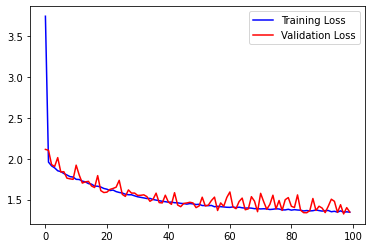

In [ ]:
plt.plot(history.history['loss'], c='blue', label='Training Loss')
plt.plot(history.history['val_loss'], c='red', label='Validation Loss')
plt.legend();

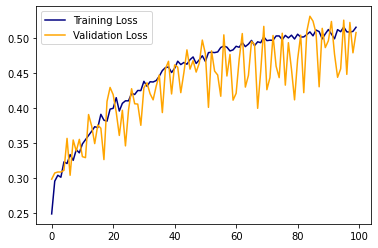

In [ ]:
plt.plot(history.history['accuracy'], c='navy', label='Training accuracy')
plt.plot(history.history['val_accuracy'], c='orange', label='Validation accuracy')
plt.legend();

There actually isn't a need to regularize our model, its not prone to overfiting. We could iterate further, incorparate batch sizing, dropouts and early stoppage as well as more layers in order to improve the overall score, but once again, that is not the aim of this project

## Conclusions:

Using tabular data in order to classify music does provide an improvement over the base case. With further iteration these models could be improved. However, using this tabular data requires in and of itself music preprocessing to find the features used for fitting, which takes time and resources, and during this process the genre itself could be surmized with the preprocessing. The purpose of this project is to provide an easy to use model with which to classify lesser known artists. We will see how our CNN models do in comparison to these models